# Wikipedia Events Analysis

## From João Neves
joao.neves\_at\_marionete.co.uk

Wikipedia is the world's largest (free) encyclopedia. Since 2001, Wikipedia has fed the users with the knowledge they needed.

To manage this information, someone must fill it in, since Wikipedia is accessible and can be editable by everyone (although there are some protected pages as stated by [Editing](https://en.wikipedia.org/wiki/Help:Editing)).

Being a worldwide platform, there are a lot of events involving Wikipedia editions, creations, etc. The data in Websocket [ws://wikimon.hatnote.com:9000](ws://wikimon.hatnote.com:9000) provides a lot of metadata about Wikipedia events. Through this data, we can analyse (for instance) what are the users doing and where from, what kind of entities mess with Wikipedia, how the users describe what are they doing... So let's do that!

In [45]:
from websocket import create_connection
import warnings
warnings.filterwarnings('ignore')
import json
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
import gensim
import random

%matplotlib inline

Read data from the websocket...! 

**Note**: the data was previously generated and saved for replication purposes.

In [2]:
# wikivents_list = list()

# num_minutes = 600

# t_end = time.time() + num_minutes*60 #run for n x 60 seconds
# ws = create_connection("ws://wikimon.hatnote.com:9000")

# while time.time() < t_end:
#     wikivents_list.append((get_current_date(),ws.recv())) #interested in time of event
    
# print(get_current_date())

# print("Collected: {} events.".format(len(wikivents_list)))

# with open("wikimon_data.pkl","wb") as f:
#     pickle.dump(wikivents_list,f)

with open("wikimon_data.pkl","rb") as f:
    wikivents_list = pickle.load(f)

# Create the dataframe

Let's parse the *jsons* and create a dataframe from the data.

In [3]:
wikivents_list_parsed = map(lambda (date, data): json.loads(data),wikivents_list)
wikivents_df = pd.DataFrame(wikivents_list_parsed)

Here we have a sample of the (final) data.

In [4]:
print wikivents_df.columns.values
wikivents_df.sample(n=1)[['action', 'change_size', 'is_bot', 'page_title']]

[u'action' u'change_size' u'flags' u'geo_ip' u'hashtags' u'is_anon'
 u'is_bot' u'is_minor' u'is_new' u'is_unpatrolled' u'mentions' u'ns'
 u'page_title' u'parent_rev_id' u'rev_id' u'summary' u'url' u'user']


,action,change_size,is_bot,page_title
8915,edit,-147.0,False,LIBOR market model


In the sample above, we see that we have several features related to **Wikipedia events**. We have the page title, the url, the change size, some flags related to the type of event (anonymous, if it was a bot, ...).

## Parse geo_ip json
*Location* field is a *json*. Here we will expand it and concatenate it to the main Dataframe.

In [5]:
#convert non null locations to dataframe
not_null_geoip = wikivents_df["geo_ip"].notnull()
location_df = pd.DataFrame(wikivents_df["geo_ip"][not_null_geoip].tolist())

#index of wikis that have location
indexes = pd.Series(wikivents_df["geo_ip"][not_null_geoip].index.values)
location_df = location_df.set_index(indexes)

In [6]:
#join both and drop column
wikivents_df = pd.concat([wikivents_df, location_df],axis = 1).drop('geo_ip', 1)

In [7]:
#select some sample data with geo_ip information
some_columns = ['user', 'city', 'country_name', 'longitude', 'latitude', 'region_name']
# if the 'city' is not null, neither are the others
not_null_location = wikivents_df['city'].notnull()
wikivents_df[not_null_location].sample(n=4)[some_columns]

,user,city,country_name,longitude,latitude,region_name
16288,74.219.222.38,Canton,United States,-81.4396,40.8996,Ohio
53680,2601:644:8103:8FC0:EDB7:B58:18F3:6314,Pleasanton,United States,-121.9374,37.6704,California
12212,74.211.95.1,Washington,United States,-113.4850,37.2262,Utah
58457,203.104.11.21,Brisbane,Australia,153.0947,-27.4724,Queensland


# The art of Data Science

Here we will try extract some knowledge from our data.

## Feature Analysis

### Action

In [8]:
wikivents_df["action"].value_counts()[:10]

edit         69321
hit           3343
create        1994
delete         532
thank          427
block          389
move           319
patrol         205
overwrite      182
reviewed        90
Name: action, dtype: int64

Most of the collected events are **edits** in Wikipedia objects that already exist.

### Change_size

In [9]:
wikivents_df["change_size"].describe()

count     69321.000000
mean        217.803609
std        4062.765972
min     -207155.000000
25%           0.000000
50%          20.000000
75%         156.000000
max      256167.000000
Name: change_size, dtype: float64

The changes are almost all around **zero** size.

In [10]:
null_sizes = wikivents_df[wikivents_df["change_size"].isnull()]

In [11]:
df = pd.concat([null_sizes["action"].rename("null_actions").value_counts(), 
           wikivents_df["action"].rename("action_count").value_counts()], axis = 1)
df[df['null_actions'].isnull()]

,null_actions,action_count
edit,NaN,69321


*change_size* is only filled when the event is an edition and an only edition event has a *change_size*.

### Flags

In [12]:
wikivents_df["flags"].value_counts(dropna = False)

NaN    51851
M      11293
B       8264
MB      2570
N       1652
!N      1483
NB       106
Name: flags, dtype: int64

Most of the flags are null. The ones that are not null are *minor* (M) and *bot* (B).

In [13]:
not_null_flags_df = wikivents_df[wikivents_df["flags"].notnull()]
df = pd.concat([not_null_flags_df["action"].rename("non_null_actions").value_counts(),
           wikivents_df["action"].rename("action_count").value_counts()], axis = 1)
df[df['non_null_actions'].notnull()]

,non_null_actions,action_count
edit,25368.0,69321


All the **non-null flags are edits**.

In [14]:
print "-"*50
print wikivents_df[wikivents_df["flags"] == "N"]["is_new"].value_counts()
print "-"*50
print wikivents_df[wikivents_df["flags"] == "NB"]["is_new"].value_counts()
print "-"*50
print wikivents_df[wikivents_df["flags"] == "!N"]["is_new"].value_counts()
print "-"*50

--------------------------------------------------
True    1652
Name: is_new, dtype: int64
--------------------------------------------------
True    106
Name: is_new, dtype: int64
--------------------------------------------------
True    1483
Name: is_new, dtype: int64
--------------------------------------------------


The events with flagged *N*, *NB* and *!N* are new events (*is_new* is True).

In [15]:
print "-"*50
print wikivents_df[wikivents_df["flags"] == "M"]["is_minor"].value_counts()
print "-"*50
print wikivents_df[wikivents_df["flags"] == "MB"]["is_minor"].value_counts()
print "-"*50

--------------------------------------------------
True    11293
Name: is_minor, dtype: int64
--------------------------------------------------
True    2570
Name: is_minor, dtype: int64
--------------------------------------------------


The events with flagged *M* and *MB* are new events (*is_minor* is True).

### Hashtags
Hashtags are lists.

In [16]:
hashtags_length = wikivents_df["hashtags"].apply(lambda x: len(x))
hashtags_length.value_counts()

0    71833
1     5376
2        9
4        1
Name: hashtags, dtype: int64

In [20]:
wikivents_df[hashtags_length > 0]["action"].value_counts()

edit       5384
byemail       1
upload        1
Name: action, dtype: int64

Most of the events do not have hashtags.

### is_bot

From the hashtags, we could see that the hashtag *IABot* exists if a bot edits

In [21]:
wikivents_df["is_bot"].value_counts()

False    66279
True     10940
Name: is_bot, dtype: int64

In [22]:
wikivents_df[wikivents_df["hashtags"].apply(lambda x: x == ["IABot"])]["is_bot"].value_counts()

True     4849
False      28
Name: is_bot, dtype: int64

In [23]:
wikivents_df[wikivents_df["hashtags"].apply(lambda x: x == ["IABot"])]["flags"].value_counts()

B    4849
Name: flags, dtype: int64

*IABot* has flags = *B*. But not the other way around.

In [24]:
wikivents_df_flags_B = wikivents_df[wikivents_df["flags"] == "B"]
wikivents_df_flags_B.sample(n=6)[['hashtags', 'is_bot']]

,hashtags,is_bot
15339,[],True
3966,[IABot],True
45784,[],True
40221,[],True
46997,[],True
40585,[IABot],True


In [25]:
wikivents_df_flags_B["hashtags"].apply(lambda x: len(x)).value_counts()

1    4849
0    3415
Name: hashtags, dtype: int64

There are *B* flags without hashtags

In [26]:
wikivents_df[wikivents_df["is_bot"] == True]["is_unpatrolled"].value_counts()

False    10940
Name: is_unpatrolled, dtype: int64

Bots are always patrolled (makes sense), assuming the *patrolled* mean that the event was somehow supervised.

### is_anon

Feature to flag if the event was made by an anonymous entity.

In [27]:
wikivents_df["is_anon"].value_counts()

False    63356
True     13863
Name: is_anon, dtype: int64

In [28]:
some_columns = ['user','is_bot', 'flags','country_name']
wikivents_df[wikivents_df["is_anon"]][some_columns].describe()

,user,is_bot,flags,country_name
count,13863,13863,33,13852
unique,6005,1,1,119
top,86.173.191.67,False,!N,United States
freq,70,13863,33,8237


The anonymous activity does not have a username and are never bots.

### is_unpatrolled

In [29]:
wikivents_df["is_unpatrolled"].value_counts()

False    75736
True      1483
Name: is_unpatrolled, dtype: int64

In [30]:
wikivents_df[wikivents_df["is_unpatrolled"]]["flags"].value_counts()

!N    1483
Name: flags, dtype: int64

Unpatrolled events always have the *!N* flag.

### ns

In [31]:
wikivents_df["ns"].value_counts()[:5]

Main         47258
Special       7898
User          5685
Talk          4824
User talk     4193
Name: ns, dtype: int64

---

From this point on, we will just focus on **edition events** since they are the most representative. Let's analyse what kind of things the editors are doing, mainly the **change size**.

In [32]:
wikivents_edits_df = wikivents_df[wikivents_df["action"] == "edit"]

## Exploratory Data Analysis

### Countries and cities with highest number of events

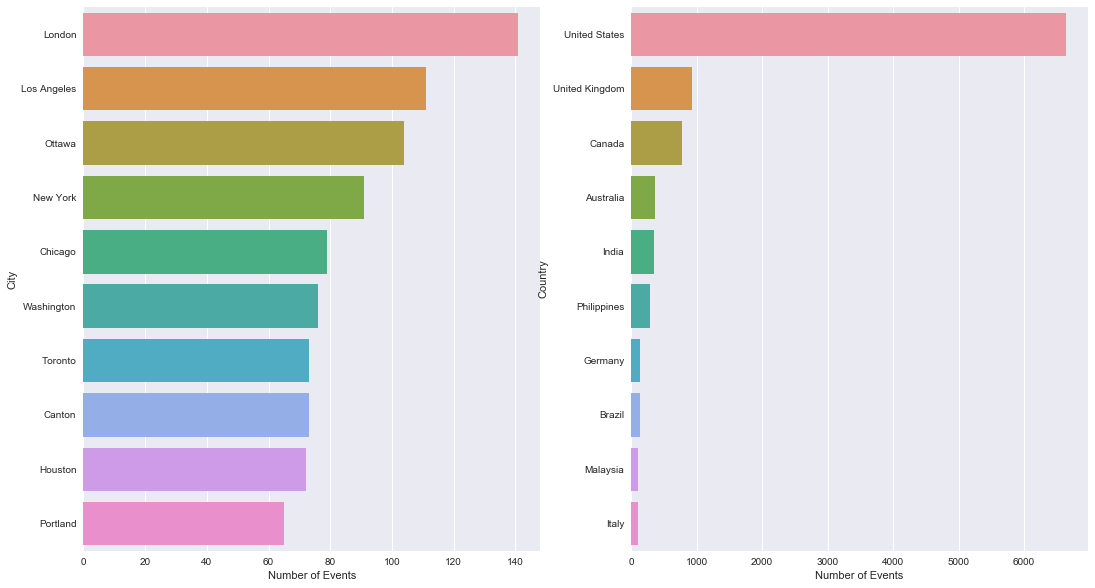

In [33]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,10))

n_highest = 10

# graphic with the cities
df1 = wikivents_edits_df["city"].value_counts()
city_order = df1.index[:n_highest]
g1 = sns.countplot(y = "city", order = city_order, data = wikivents_edits_df, ax=ax1)
g1.set_ylabel("City")
g1.set_xlabel("Number of Events")

# graphic with the countries
df2 = wikivents_edits_df["country_name"].value_counts()
country_order = df2.index[:n_highest]
g2 = sns.countplot(y = "country_name", order = country_order,
                   data = wikivents_edits_df, ax=ax2)
g2.set_ylabel("Country")
g2.set_xlabel("Number of Events")

We check that London is the city with the most Wikipedia events and the USA are the country with the most Wikipedia events.

From the cities with more events, most of them are from the USA.

### Countries with the highest average change size

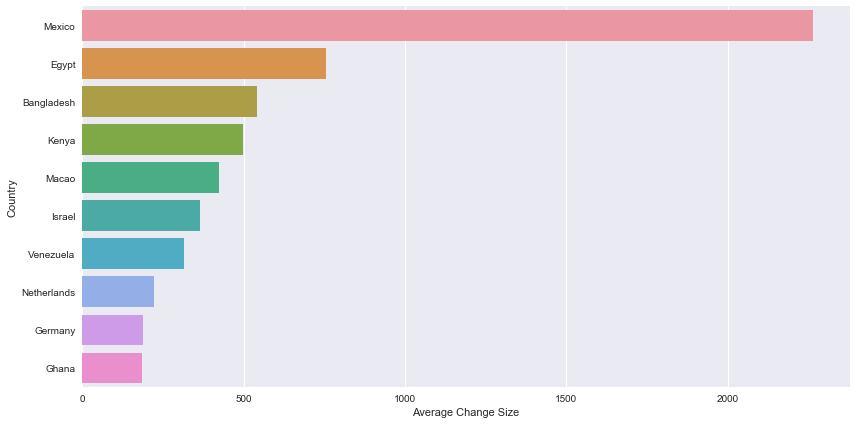

In [34]:
n_highest = 10

dict = {"change_size":np.mean}

# get the data
grouped = wikivents_edits_df.groupby(["country_name"])
df1 = grouped.agg(dict).sort_values(["change_size"],
                                    ascending = False)[:n_highest]
df1["country_name"] = df1.index

# plot the data
g1 = sns.factorplot(y = "country_name", x = "change_size",
                    data = df1, kind="bar", aspect=2, size=6)
g1.set_ylabels("Country")
g1.set_xlabels("Average Change Size")

Although, when it comes to change size, Mexico is actually the country with the most change size per event in average.

So, even if the USA is the country with more events, the change size per event is low. In Mexico, the number of events is low but the change size is high per event.

### Cities with the highest average change size

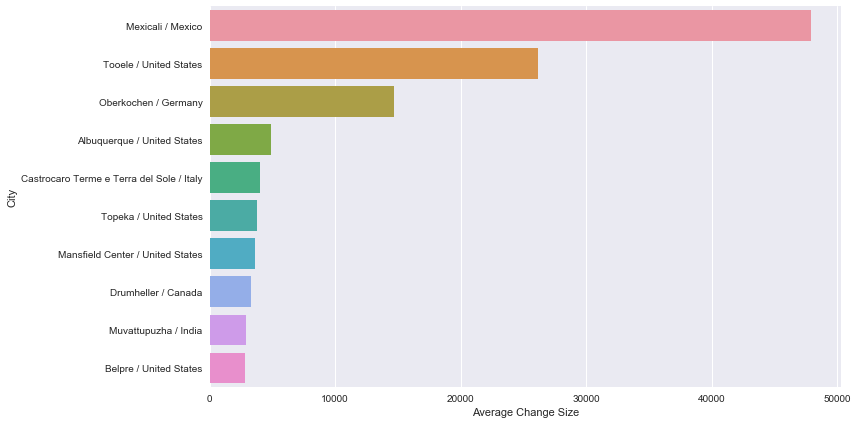

In [35]:
n_highest = 10

dict = {"change_size":np.mean}

# get the data
grouped = wikivents_edits_df.groupby(["city","country_name"])
df = grouped.agg(dict).sort_values(["change_size"],
                                   ascending = False)[:n_highest]
df["city_and_country"] = map(lambda (city, country): city + " / " + country,
                             df.index)

# plot the data
g = sns.factorplot(y = "city_and_country", x = "change_size",
                   data = df, kind="bar", aspect=2, size=6)
g.set_ylabels("City")
g.set_xlabels("Average Change Size")

Mexicali in Mexico is the city where change sizes are higher per event although most of the cities are from USA.

### Most edited pages (average)

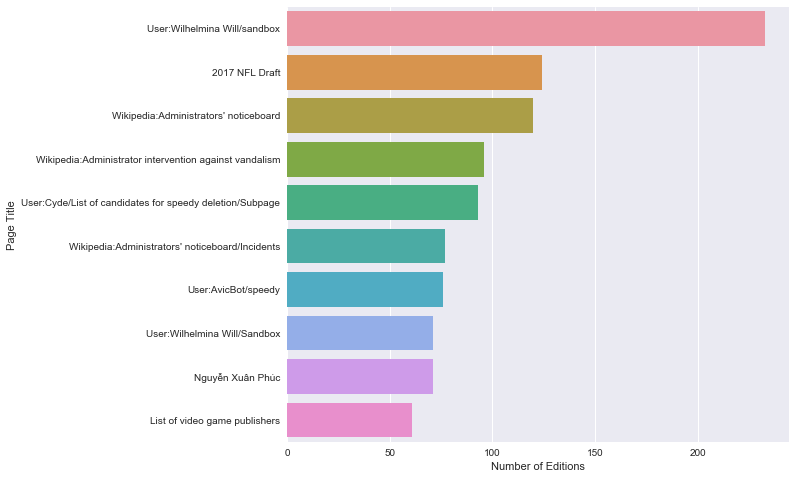

In [36]:
plt.figure(figsize=(9,8))

n_highest = 10

df = wikivents_edits_df["page_title"].value_counts()
page_order = df.index[:n_highest]
g = sns.countplot(y = "page_title", data = wikivents_edits_df, order = page_order)
g.set_ylabel("Page Title")
g.set_xlabel("Number of Editions")

The most edited page is a user page with more than 200 editions. There are just three main pages in the top 10: *2017 NFL Draft*, *Nguyēn Xuân Phüc*, and *List of video game publishers*.

### Most active users (number of events)

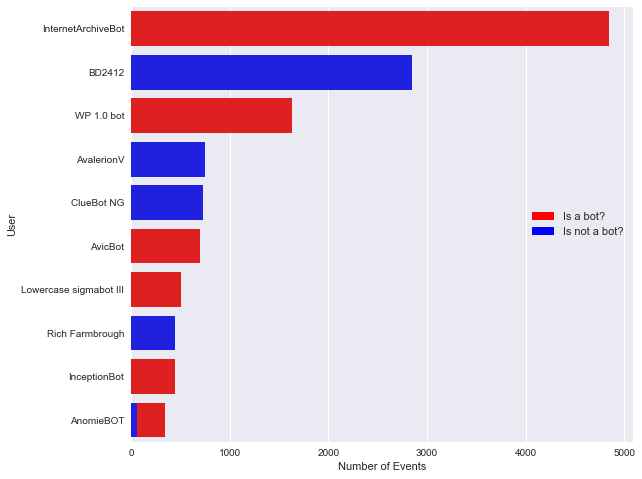

In [47]:
plt.figure(figsize=(9,8))
n_highest = 10

# indexes of the users sorted by number of events
user_order = wikivents_edits_df["user"].value_counts().index[:n_highest]

# plot with the "is bot"'s
## select the respective data
is_bot = wikivents_edits_df["is_bot"]
is_bot_sorted = wikivents_edits_df[is_bot]["user"].value_counts().loc[user_order]
## plot the data
g1 = sns.barplot(y = is_bot_sorted.index, x = is_bot_sorted, color="red")
g1_legend = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')

# plot with the non "is bot"'s
## select the respective data
is_not_bot = wikivents_edits_df["is_bot"]==False
is_not_bot_sorted = wikivents_edits_df[is_not_bot]["user"].value_counts().loc[user_order]
## plot the data
g2 = sns.barplot(y = is_not_bot_sorted.index, x = is_not_bot_sorted, color="blue")
g2_legend = plt.Rectangle((0,0),1,1,fc='blue',  edgecolor = 'none')

g2.set_ylabel("User")
g2.set_xlabel("Number of Events")
l = plt.legend([g1_legend, g2_legend], ['Is a bot?','Is not a bot?'],
               loc=5, ncol = 1, prop={'size':11})
sns.despine(left=True)

The most active user is a bot which looks like some kind of *archive bot*.

### Most active users (average change per event)

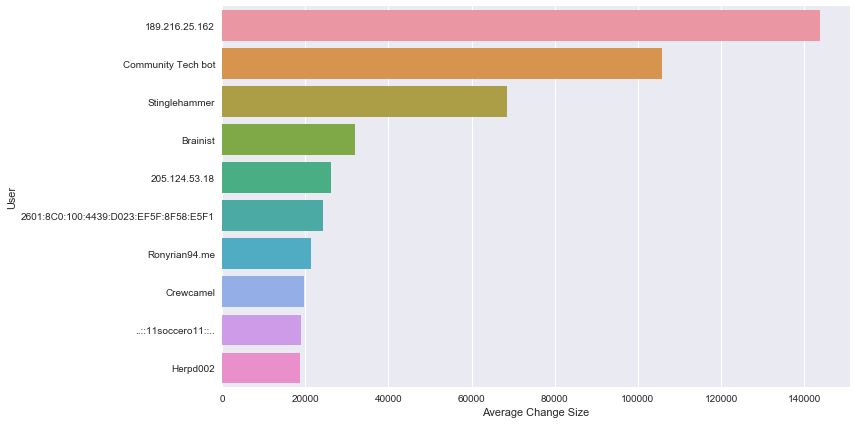

In [38]:
n_highest = 10

dict = {"change_size":np.mean}

# get the data
grouped = wikivents_edits_df.groupby(["user"])
average_change_size_by_user = grouped.agg(dict).sort_values(["change_size"]
                                                            ,ascending = False)[:n_highest]
average_change_size_by_user["user"] = average_change_size_by_user.index

# plot the data
g = sns.factorplot(y = "user", x = "change_size",
                   data = average_change_size_by_user,
                   kind="bar", aspect=2, size=6)
g.set_ylabels("User")
g.set_xlabels("Average Change Size")

Non-anonymous users are responsible for higher chance sizes per event in average.

## Let's play a little...

Let's grab the summary of the editions and check what a Word2Vec model trained with these texts would be...

First, let's make some basic NLP processing in the summary text.

In [39]:
# pattern to remove everything that is not words and whitespaces
pattern = re.compile(r"[^a-zA-Z\s]*")

# select only non null summaries
df = wikivents_edits_df[wikivents_edits_df["summary"].notnull()]["summary"]
sentences = map(lambda record: pattern.sub(lambda match: "", record), df.values)

In [40]:
training_sentences = []

# lower case and split the sentences
for sentence in sentences:
    training_sentences.append(sentence.lower().split())
    
print "Our training data has {} sentences.".format(len(training_sentences))

Our training data has 57493 sentences.


Train the model. We must be aware that such a complex model needs a lot of data for training and some iterations which is not the case. This is just an ilustration of an interesting approach.

In [ ]:
# we are just training to generate features of size two (which is very low)
# but this is just because of time restrictions

# model = gensim.models.Word2Vec(training, size=2, window=6, min_count=5)
# model.save("model_example.model")

**note**: the model was previously trained (with the parameters below) and locally saved to reuse.

In [41]:
model = gensim.models.Word2Vec.load("model_example.model")

In [42]:
def collect_word_vecs(model):
    for word in model.wv.vocab.keys():
        yield model.wv[word]
        
def collect_vocabulary_words(model):
    for word in model.wv.vocab.keys():
        yield word

word_vecs = list(collect_word_vecs(model))

words = list(collect_vocabulary_words(model))

In [43]:
model.wv.most_similar("portugal")

[(u'restoration', 0.9999997019767761),
 (u'coast', 0.9999996423721313),
 (u'issue', 0.9999996423721313),
 (u'festivals', 0.9999996423721313),
 (u'shift', 0.9999995827674866),
 (u'make', 0.9999994039535522),
 (u'navy', 0.9999994039535522),
 (u'wpnpov', 0.9999992847442627),
 (u'wikilove', 0.9999985694885254),
 (u'advert', 0.9999985098838806)]

For some reason, the models thinks that *portugal* is near *festivals*, *restoration* and *coast* which is somehow interesting because Portugal is in the west edge of Europe, is famous for its restoration and for its music festivals.

Let's see the word representation of some of these words.

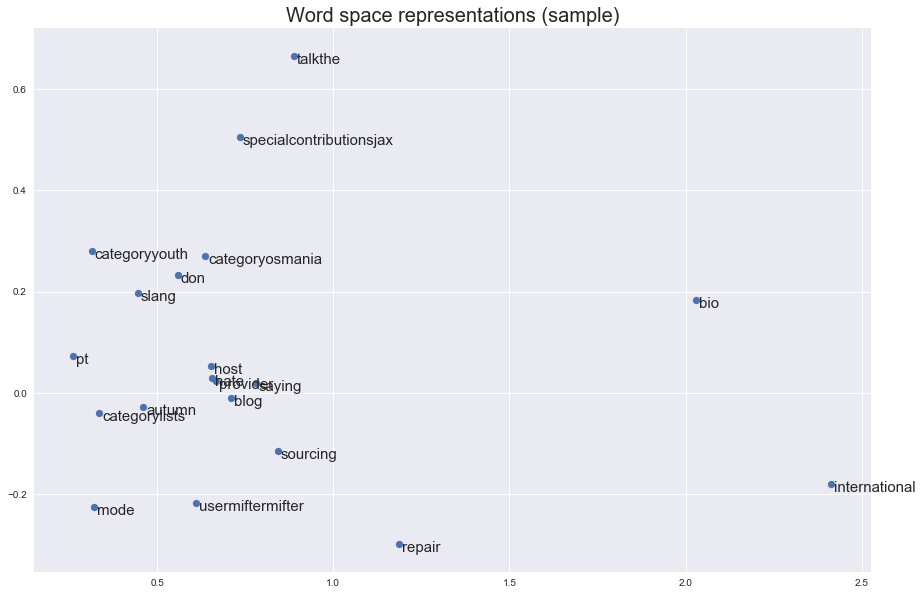

In [46]:
# some words taken from the dictionary (variable 'words')
some_words = ["talkthe","specialcontributionsjax","categoryyouth",
              "categoryosmania","don","slang","pt","host","blog","autumn",
             "categorylists","sourcing","hate","provider","saying",
             "mode","usermiftermifter","repair","international","bio"]
indexes = [i for i in range(len(words)) if words[i] in some_words]

# get the data
x = map(lambda (x,y): x,word_vecs)
y = map(lambda (x,y): y,word_vecs)
x_sample = [x[i] for i in indexes]
y_sample = [y[i] for i in indexes]

# plot the data
plt.figure(figsize=(15,10))
plt.scatter(x_sample,y_sample,marker="o")
plt.title("Word space representations (sample)", size = 20)

# annotate the points with the word they are representing
for i, w in enumerate([words[i] for i in indexes]):
    plt.annotate(
        w.decode('utf-8', 'ignore'),
        xy = (x_sample[i], y_sample[i]), xytext = (3, 3),
        textcoords = 'offset points', ha = 'left', va = 'top', fontsize = 15)

We conclude that the model capture some word semantics and syntax. For instance, we have some notion about the proximity of the words according to our vocabulary. For instance, *categoryyouth* is near *categoryosmania*, probably because they have *category* in common. On the other side *bio* is far from *slang*. 